In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.signal import spectrogram
import matplotlib.pyplot as plt
from piaxi_numerics import set_params, solve_system, get_text_params

In [2]:
# Set constants of model
e    = 0.3      # dimensionless electron charge
F    = 1e11    # pi-axion decay constant (GeV)
#F = 100
p_t  = 0.4      # total local DM density (GeV/cm^3)

## Tuneable constants
# millicharge, vary to enable/disable charged species (10e-15 = OFF, 10e-25 = ON)
#eps  = 1e-25   # (unitless)
eps  = 1

# Coupling constants
L3   = 1e11    # (GeV)
#L3 = 100
L4   = 1e11    # (GeV)
#L4 = 100
l1   = 1       #
l2   = 1       #
l3   = 1       #
l4   = 1       #

# Unit scaling:
GeV  = 1e9     # GeV -> eV
#GeV = 1
F   *= GeV
p_t *= GeV
L3  *= GeV
L4  *= GeV

In [3]:
# Initial Conditions
A_0    = 0.1
Adot_0 = 0.0
A_pm   = +1      # specify A± case (+1 or -1)

In [4]:
# Time domain
t_span = [0, 10]  # TODO: replace with the appropriate values
t_N    = 500      # Number of timesteps

# k values
k_span = [1, 200] # TODO: replace with the appropriate values
k_N = 200         # Number of k-modes

In [5]:
# Parameters of model

# masses for real, complex, and charged species in range (10e-8, 10e-4)
#m_scale = 1e-8              # eV
m_scale = 1
m = m_scale * np.array([1., 3., 5.])

# local DM densities/amplitudes for each species
p    = np.array([1/3, 1/3, 1/3]) * p_t
amps = [np.sqrt(2 * p[i]) / m[i] for i in range(len(m))]

# local phases for each species (to be sampled)
d    = [0, 0, 0]   # (0, 2pi)
d_sample = True

# global phase for neutral complex species (to be sampled)
Th   = [0, 0, 0]   # (0, 2pi)
Th_sample = True

In [6]:
# Sample phases from normal distribution, between 0 and 2pi
mu  = np.pi      # mean
sig = np.pi / 3  # standard deviation

# Modulo 2pi to ensure value is within range
if d_sample:
        d = [np.mod(np.random.normal(mu, sig), 2*np.pi) for d_i in d]
if Th_sample:
        Th = [np.mod(np.random.normal(mu, sig), 2*np.pi) for Th_i in Th]

In [7]:
## Define the system of ODEs
# TODO: Finish defining time-dependent functions P(t), B(t), C(t), D(t) here
#       - Verify they are the correct form, double check all signs and factors of 2
# NOTE: Using cosine definitons for amplitudes
#       i = {0,1,2} correspond to {pi_0, pi, pi_+/-} respectively

# Define helper functions to clean up differential equation
P = lambda t, l3=l3, L3=L3, l4=l4, L4=L4, eps=eps, amps=amps, m=m, d=d, Th=Th, np=np: \
            4*l3/(L3**2) * eps**2 * (np.abs(amps[2])**2 * np.cos(m[2]*t + d[2])**2) + \
            4*l4/(L4**2) * eps**2 * (np.abs(amps[1])**2 * np.cos(m[1]*t + d[1])**2 + \
                                     np.abs(amps[0])**2 * np.cos(m[0]*t + d[0])**2 + \
                                     2*np.abs(amps[0])*np.abs(amps[1]) * np.cos(m[0]*t + d[0])*np.cos(m[1]*t + d[1]) * np.cos(Th[1]))

B = lambda t, l3=l3, L3=L3, l4=l4, L4=L4, eps=eps, amps=amps, m=m, d=d, Th=Th, np=np: \
            (-1)*8*l3/(L3**2) * eps**2 * (np.abs(amps[2])**2 * m[2] * np.sin(m[2]*t + d[2])**2 * np.cos(m[2]*t + d[2])**2) + \
            (-1)*8*l4/(L4**2) * eps**2 * (np.abs(amps[0])**2 * m[0] * np.sin(m[0]*t + d[0])**2 * np.cos(m[0]*t + d[0])**2 + \
                                          np.abs(amps[1])**2 * m[1] * np.sin(m[1]*t + d[1])**2 * np.cos(m[1]*t + d[1])**2 + \
                                          np.abs(amps[1])*np.abs(amps[0]) * np.cos(Th[1]) * \
                                              (m[0] * np.sin(m[0]*t + d[0])**2 * np.cos(m[1]*t + d[1])**2 + \
                                               m[1] * np.sin(m[1]*t + d[1])**2 * np.cos(m[0]*t + d[0])**2))

C = lambda t, pm, l1=l1, F=F, eps=eps, amps=amps, m=m, d=d, np=np: \
            (-1) * pm * (2*l1 / F * eps**2) * np.abs(amps[0]) * m[0] * np.sin(m[0]*t + d[0])

D = lambda t, l2=l2, e=e, eps=eps, amps=amps, m=m, d=d, np=np: \
            2*l2 * eps**2 * e**2 * np.abs(amps[2])**2 * np.cos(m[2]*t + d[2])**2

def local_system(t, y, k, params, P=P, B=B, C=C, D=D, A_pm=A_pm):
    
    # System of differential equations to be solved
    dy0dt = y[1]
    dy1dt = -1/(1 + P(t)) * (B(t)*y[1] + (C(t, A_pm)*k + D(t))*y[0]) - k**2*y[0]
    return [dy0dt, dy1dt]

In [8]:
# Solve the differential equation for each k

k_values, k_step = np.linspace(k_span[0], k_span[1], k_N, retstep=True)
#k_values = np.linspace(1./100, 10, 100)

# Initialize an array to store the solutions
t, t_step = np.linspace(t_span[0], t_span[1], t_N, retstep=True)  # Array of times at which to evaluate

# Set all parameters on the backend
parameters = {"e": e, "F": F, "p_t": p_t, "eps": eps, "L3": L3, "L4": L4, "l1": l1, "l2": l2, "l3": l3, "l4": l4,
              "A_0": A_0, "Adot_0": Adot_0, "A_pm": A_pm, "m": m, "p": p, "amps": amps, "d": d, "Th": Th}
params = set_params(parameters, t_min=t_span[0], t_max=t_span[1], t_N=t_N, k_min=k_span[0], k_max=k_span[1], k_N=k_N)

# Solve the system, in parallel
solutions, timestr = solve_system(local_system, jupyter=True, parallelize=True, num_cores=4)
print(timestr)

0:02:02.953000 on 4 cores


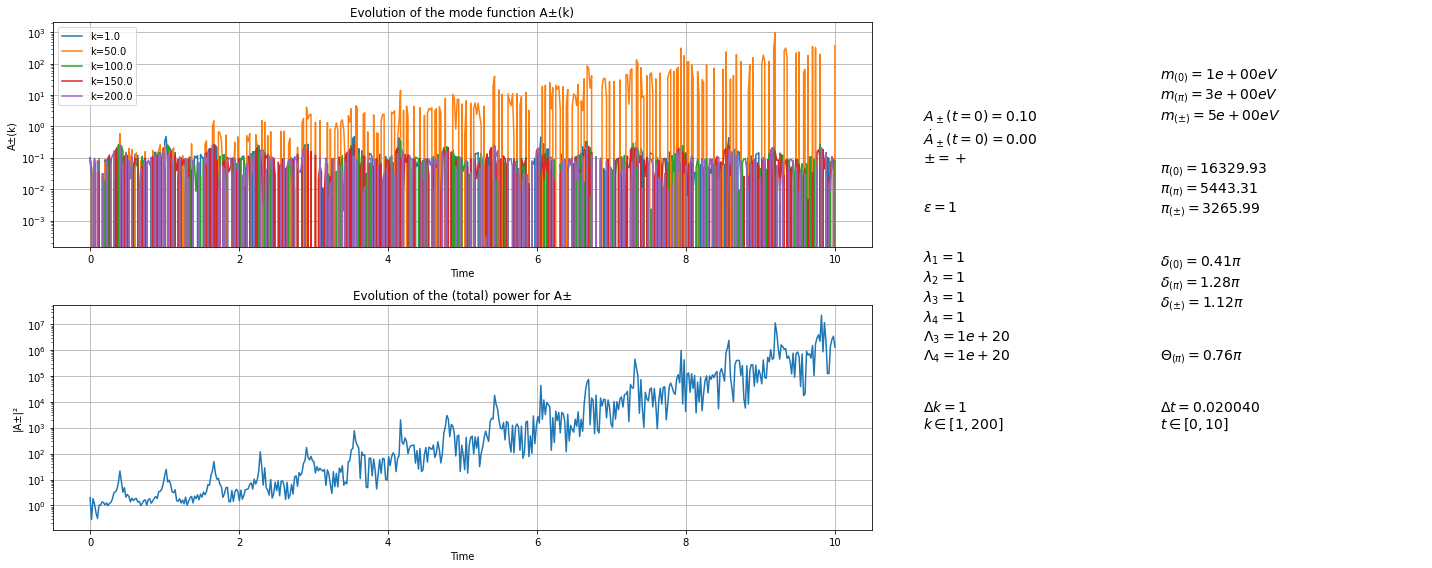

In [9]:
# Plot the solution
signstr = {1: "+", -1: "-", 0: "±"}
#k_samples = np.geomspace(1,len(k_values),num=5)
k_samples = [i for i, k_i in enumerate(k_values) if k_i in [1,50,100,150,200]]
times = t

plt.figure(figsize=(20, 8))

#plt.subplot(2,1,1)
plt.subplot2grid((2,5), (0,0), colspan=3)
for k_sample in k_samples:
    k_s = int(k_sample)
    #print(solutions[k_s, 0])
    plt.plot(times, solutions[k_s][0], label='k='+str(k_values[k_s]))
plt.title('Evolution of the mode function A'+signstr[0]+'(k)')
plt.xlabel('Time')
plt.ylabel('A'+signstr[0]+'(k)')
plt.yscale('log')
plt.legend()
plt.grid()

#plt.subplot(2,1,2)
plt.subplot2grid((2,5), (1,0), colspan=3)
plt.plot(times, [sum([np.abs(solutions[i][0][t_i])**2 for i in range(len(k_values))]) for t_i in range(len(times))])
plt.title('Evolution of the (total) power for A'+signstr[0])
plt.xlabel('Time')
plt.ylabel('|A'+signstr[0]+'|²')
plt.yscale('log')
plt.grid()

textstr1, textstr2 = get_text_params()

plt.subplot2grid((2,5), (0,3), rowspan=2)
plt.text(0.15, 0.2, textstr1, fontsize=14)
plt.axis('off')

plt.subplot2grid((2,5), (0,4), rowspan=2)
plt.text(0, 0.2, textstr2, fontsize=14)
plt.axis('off')

plt.tight_layout()
plt.show()

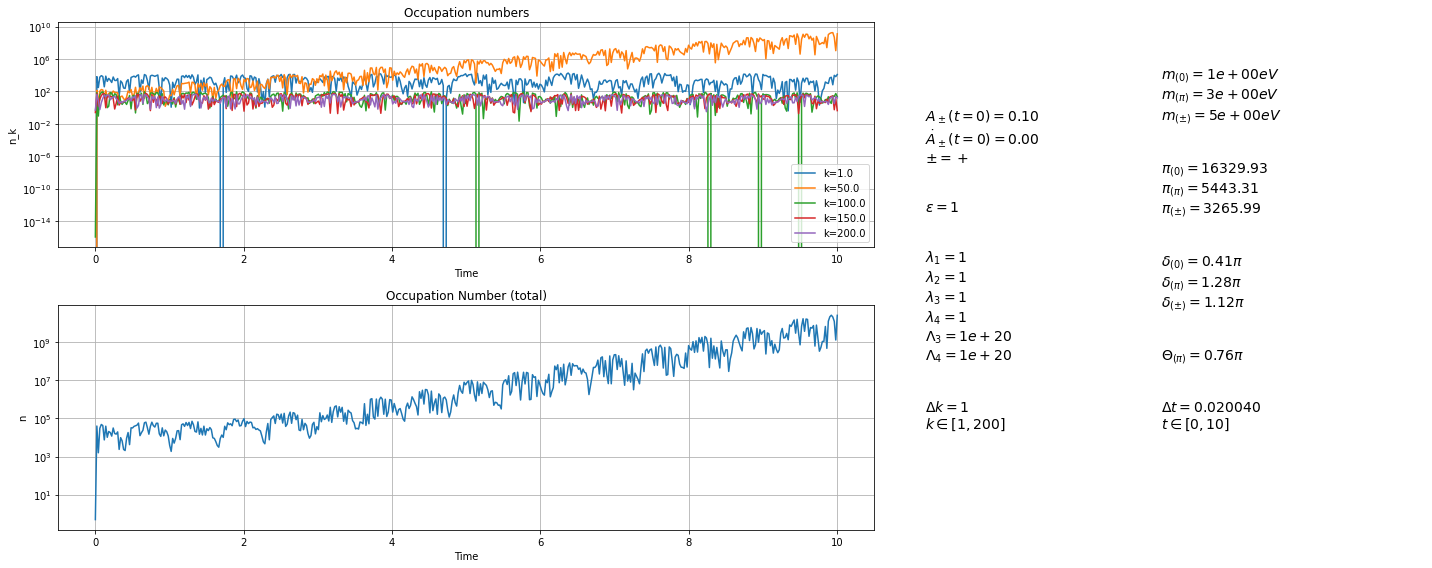

In [10]:
# Plot the occupation numbers
w = lambda i: np.abs(k_values[i])
n = lambda i: (w(i)/2) * (((np.square(np.abs(solutions[i][1])))/(np.square(w(i)))) + np.square(np.abs(solutions[i][0]))) - (1/2)
times = t

#k_samples = np.geomspace(1,len(k_values),num=5)
k_samples = [i for i, k_i in enumerate(k_values) if k_i in [1,50,100,150,200]]
plt.figure(figsize=(20, 8))

plt.subplot2grid((2,5), (0,0), colspan=3)
for k_sample in k_samples:
    k_s = int(k_sample)
    plt.plot(times, n(k_s), label='k='+str(k_values[k_s]))
plt.title('Occupation numbers')
plt.xlabel('Time')
#plt.xlim(0,0.2)
plt.ylabel('n_k')
plt.yscale('log'); #plt.ylim(bottom = 0.1)
plt.legend()
plt.grid()

plt.subplot2grid((2,5), (1,0), colspan=3)
plt.plot(times, [sum([n(i)[t_i] for i in range(len(k_values))]) for t_i in range(len(times))])
plt.title('Occupation Number (total)')
plt.xlabel('Time')
#plt.xlim(0,0.1)
plt.ylabel('n')
plt.yscale('log')
plt.grid()

textstr1, textstr2 = get_text_params()

plt.subplot2grid((2,5), (0,3), rowspan=2)
plt.text(0.15, 0.2, textstr1, fontsize=14)
plt.axis('off')

plt.subplot2grid((2,5), (0,4), rowspan=2)
plt.text(0, 0.2, textstr2, fontsize=14)
plt.axis('off')

plt.tight_layout()
plt.show()

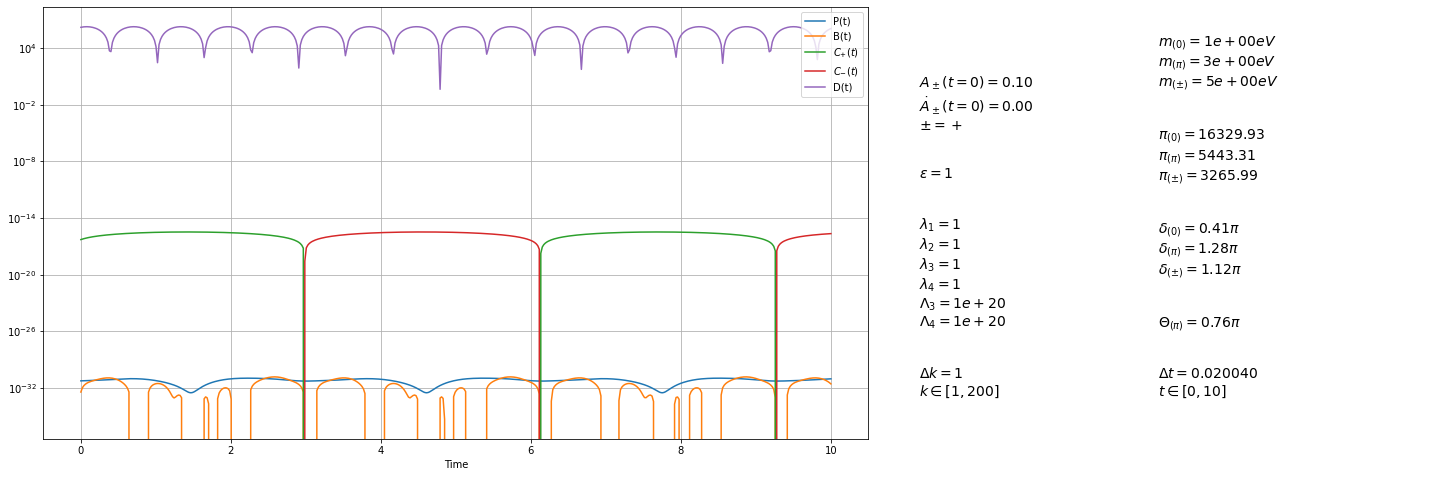

In [11]:
# Compare model coefficient values over time
plt.figure(figsize = (20,7))
times = t

plt.subplot2grid((2,5), (0,0), colspan=3, rowspan=2)
plt.plot(times, P(times),label="P(t)")
plt.plot(times, B(times),label="B(t)")
plt.plot(times, C(times,+1),label="$C_{%s}(t)$" % signstr[+1])
plt.plot(times, C(times,-1),label="$C_{%s}(t)$" % signstr[-1])
plt.plot(times, D(times),label="D(t)")

plt.xlabel('Time')
plt.yscale('log')
plt.grid()
plt.legend()

textstr1, textstr2 = get_text_params()

plt.subplot2grid((2,5), (0,3), rowspan=2)
plt.text(0.15, 0.1, textstr1, fontsize=14)
plt.axis('off')

plt.subplot2grid((2,5), (0,4), rowspan=2)
plt.text(0, 0.1, textstr2, fontsize=14)
plt.axis('off')

plt.tight_layout()
plt.show()

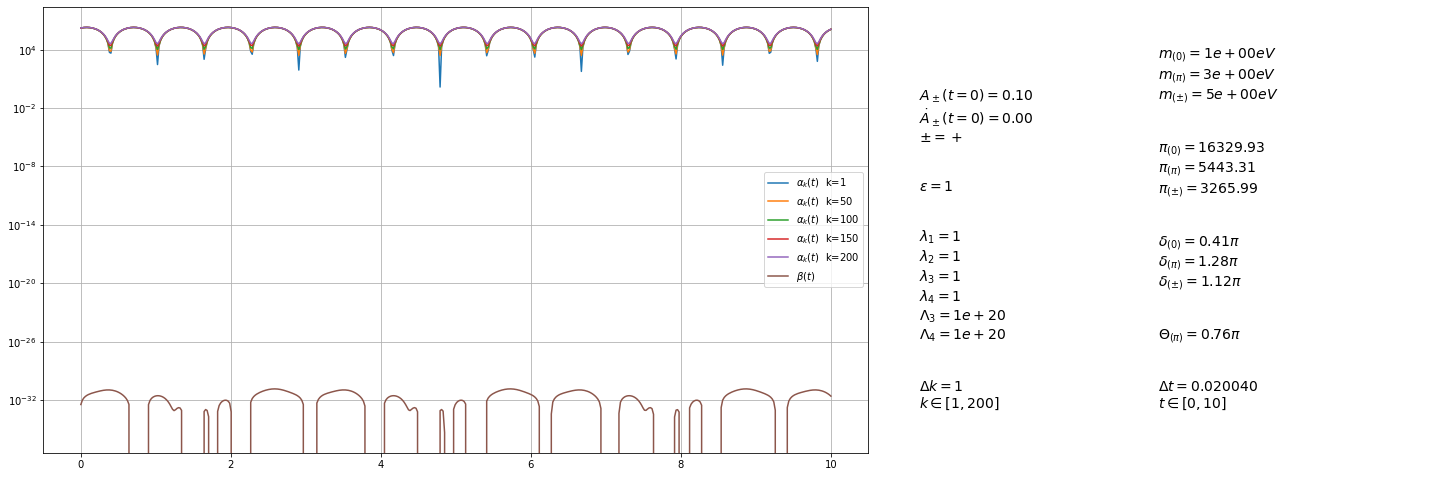

In [12]:
# Compare Alpha(t) and Beta(t) for a sampling of k values
times = t
Alpha = lambda t, k: (k**2 + C(t, A_pm)*k + D(t)) / (1 + P(t))
Beta = lambda t: B(t) / (1 + P(t))

plt.figure(figsize = (20,7))
plt.subplot2grid((2,5), (0,0), colspan=3, rowspan=2)

#k_samples = np.geomspace(1,len(k_values),num=5)
k_samples = [i for i, k_i in enumerate(k_values) if k_i in [1,50,100,150,200]]
for k_sample in k_samples:
    k_s = int(k_sample)
    plt.plot(times, Alpha(times, k_values[k_s]), label=r"$\alpha_k(t)$  k=%d" % k_values[k_s])

plt.plot(times, Beta(times), label=r"$\beta(t)$")

plt.grid()
plt.yscale('log')
plt.legend()

textstr1, textstr2 = get_text_params()

plt.subplot2grid((2,5), (0,3), rowspan=2)
plt.text(0.15, 0.1, textstr1, fontsize=14)
plt.axis('off')

plt.subplot2grid((2,5), (0,4), rowspan=2)
plt.text(0, 0.1, textstr2, fontsize=14)
plt.axis('off')

plt.tight_layout()
plt.show()